In [2]:
import gc
 
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)

Garbage collector: collected 23 objects.


In [58]:
del df

In [57]:
%%time
# cell for memory management
# run it to see the memory which each variable is using and delete them
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

           transactions_merged: 33.5 GiB
                  transactions:  5.2 GiB
                     customers: 512.9 MiB
                            df: 512.9 MiB
         customer_group_merged: 365.1 MiB
              customer_grouped: 241.4 MiB
            customer_grouped_3: 232.2 MiB
            customer_grouped_2: 198.2 MiB
                      articles: 117.6 MiB
                           _15:  8.6 KiB
Wall time: 52.9 s


# Exploratory Data Analysis: H&M Transaction Data

H&M (Hennes & Mauritz AB) is a Swedish multinational clothing company headquartered in Stockholm. Its  focus is fast-fashion clothing for men, women, teenagers and childern. Its market capitalization is 20.68 billion USD and it has more than 5,000 stores in 74 countries. As an international fast-fashion brand, its product portfolio serves the diverse needs of customers all around the world. Thus, it faces a challenge of recommending proper items to each customer. \
In this notebook, I will conduct exploratory data anlysis of H&M's customers, articles, and transactions data to better understand the data and get insights to build a recommendation model.

## 0. Data Preparation

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

import dask
import dask.dataframe as dd

In [4]:
# Custom functions
def df_summary(df):
    """
    provide brief information about a dataframe
    """
    assert isinstance(df, pd.DataFrame)
    print('===the first rows===')
    display(df.head())
    print(f'The shape of the dataset:{df.shape}')
    print(f'The features of the dataset:{list(df.columns)}')
    print(f'{df.isnull().any().sum()} features have missing values')
    print(f'{(df.apply(lambda x: x.nunique()) == 1).sum()} features have one unique value')
    
def df_unique(df,cutoff=100):
    """
    print unique values for each column
    cutoff: a limit to skip a column with too many unique values
    """
    print("=======Unique values of each column=======")
    for col in df.columns:
        print(f"==={col} Column===")
        vals = df[col].unique()
        if len(vals) > cutoff:
            print(f"There are {len(vals)} unique vales. Only showing limited number of examples.\n{vals[0:10]}")
        else:
            print(vals)    

def reduce_mem_usage(df):
    # From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage , modified by Minseok Song
    # WARNING! THIS CAN DAMAGE THE DATA 
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.         
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type not in [object,'<M8[ns]']: # added datetime dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
# loda data
data_path = Path("../data")
articles = pd.read_csv(data_path /"articles.csv")
customers = pd.read_csv(data_path /"customers.csv")
transactions = pd.read_csv(data_path /"transactions_train.csv")

## 0.1 Data Pre-processing

### 0.1.1 NA values handling

In [6]:
# handling NA values
customers['FN'] = customers['FN'].fillna(0) # fill NaN with 0 in FN column since it's binary
customers['Active'] = customers['Active'].fillna(0) # fill NaN with 0 in 'Active' column since it's binary
customers['club_member_status'] = customers['club_member_status'].fillna('NOT MEMBER') # fill NaN with the value. It's categorical
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace(dict.fromkeys([np.nan,'None'],'NONE')) #fill NaN with the value. It's categorical
# customers['age'].fillna(int(np.mean(customers['age'])), inplace=True) # there are 15861 rows with NaN 'age' value. we replace with the mean of all customers age.

In [24]:
# change dtype of t_dat column and add year, month columns
transactions['t_dat'] = transactions.t_dat.astype('datetime64')
transactions['year'] = pd.DatetimeIndex(transactions.t_dat).year
transactions['month'] = pd.DatetimeIndex(transactions.t_dat).month
transactions['week'] = pd.DatetimeIndex(transactions.t_dat).week

C:\Users\cosni\miniconda3\envs\hnm_recs\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


### 0.2 Summary of Each Dataset

In [25]:
for name, df in zip(['transactions','articles','customers'],[transactions,articles,customers]):
    print(f'==========Name of DataFrame: {name}==========')
    df_summary(df)
    print('\n')

==========Name of DataFrame: transactions==========
===the first rows===


t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  year  month  week  
0  0.050831                 2  2018      9    38  
1  0.030492                 2  2018      9    38  
2  0.015237                 2  2018      9    38  
3  0.016932                 2  2018      9    38  
4  0.016932                 2  2018      9    38

The shape of the dataset:(31788324, 8)
The features of the dataset:['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id', 'year', 'month', 'week']
0 features have missing values
0 features have one unique value


==========Name of DataFrame: articles==========
===the first rows===


article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid                 10             White  ...   
2                    Stripe                 11         Off White  ...   
3                     Solid                  9             Black  ...   
4                     Solid                 10             White  ...   

   department_name index_code        index_name index_group_no  \
0     Jersey Basic          A        Ladieswear              1   
1     Jersey Basic          A        Ladieswear              1   
2     Jersey Basic          A        Ladieswear              1   
3   Clean Lingerie          B  Lingeries/Tights              1   
4   Clean Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no            section_name garment_group_no  \
0        Ladieswear         16  Womens Everyday Basics             1002   
1        Ladieswear         16  Womens Everyday Basics             1002   
2        Ladieswear         16  Womens Everyday Basics             1002   
3        Ladieswear         61         Womens Lingerie             1017   
4        Ladieswear         61         Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1        Jersey Basic            Jersey top with narrow shoulder straps.  
2        Jersey Basic            Jersey top with narrow shoulder straps.  
3   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  

[5 rows x 25 columns]

The shape of the dataset:(105542, 25)
The features of the dataset:['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']
1 features have missing values
0 features have one unique value


==========Name of DataFrame: customers==========
===the first rows===


customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  0.0     0.0   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  0.0     0.0   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.0     0.0   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  0.0     0.0   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

The shape of the dataset:(1371980, 7)
The features of the dataset:['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']
1 features have missing values
0 features have one unique value




# 1. Exploratory Data Analysis

In [26]:
# merge transactions and articles data
transactions_merged = pd.merge(transactions, articles, how='left', on='article_id')
transactions_merged = transactions_merged.drop(columns = ['detail_desc']) # drop the description columns as it's not needed

## 1.1 Values in the Dataframe

I'll print out unique values in each column to understand the dataset better.

In [27]:
df_unique(transactions_merged)

=======Unique values of each column=======
===t_dat Column===
There are 734 unique vales. Only showing limited number of examples.
['2018-09-20T00:00:00.000000000' '2018-09-21T00:00:00.000000000'
 '2018-09-22T00:00:00.000000000' '2018-09-23T00:00:00.000000000'
 '2018-09-24T00:00:00.000000000' '2018-09-25T00:00:00.000000000'
 '2018-09-26T00:00:00.000000000' '2018-09-27T00:00:00.000000000'
 '2018-09-28T00:00:00.000000000' '2018-09-29T00:00:00.000000000']
===customer_id Column===
There are 1362281 unique vales. Only showing limited number of examples.
['000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318'
 '00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2'
 '00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4c73235dccbbc132280'
 '0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2'
 '000aa7f0dc06cd7174389e76c9e132a67860c5f65f970699daccc14425ac31a8'
 '001127bffdda108579e6cb16080440e89bf1250a776c6e55f56e35e9ee029a8d'
 '001ea4e9c54f7e9c88811260d954edc059d

**Most columns are categorical with limited number of options. I'll like to do a deepdive into a category distribution.**

## 1.2 Distribution of Items sold by Categories

**Category Structure**

```
Index Group : Ladieswear, Divided, Menswear, ...
└───Index : Ladieswear, Lingeries/Tights, Divided, Menswear, ...
│   └───Section : Womens Everyday Collection, Womens Langerie, Divided Collection, Men Underwear, ...
│   │   └───Product Type: Trousers, Bra, T-shirt
│   │   │   └───Product: Jade HW Skinny Denim TRS,
│   │   │   │   └───Article:
```

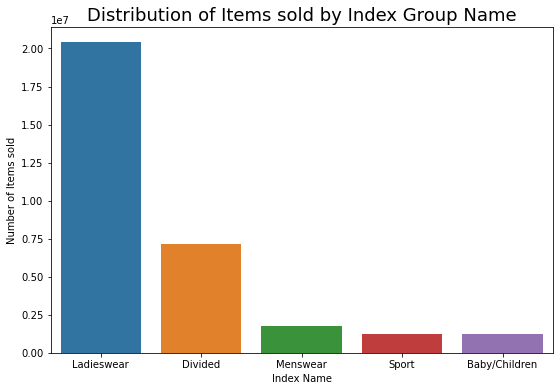

In [28]:
plt.figure(figsize = (9,6))
ax = sns.countplot(x="index_group_name", data=transactions_merged, order = transactions_merged['index_group_name'].value_counts().index)
ax.set_title('Distribution of Items sold by Index Group Name', fontsize=18)
ax.set_xlabel('Index Name')
ax.set_ylabel('Number of Items sold')
plt.show()

In [29]:
transactions_merged['index_group_name'].value_counts() / len(transactions_merged) * 100

Ladieswear       64.222511
Divided          22.455585
Menswear          5.571395
Sport             3.920962
Baby/Children     3.829548
Name: index_group_name, dtype: float64

**The Ladieswear category accounts for 64% of the total number of items sold. Women's cateogories account for 86.67% given that 'Divided' is a category for young female customer.**

In [30]:
# show top product types for each index group
(transactions_merged[transactions_merged['index_group_name'] == 'Ladieswear']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name        section_name                product_type_name
Ladieswear        Ladieswear        Womens Everyday Collection  Trousers             3.702872
                  Lingeries/Tights  Womens Lingerie             Bra                  3.505334
                                    Womens Swimwear, beachwear  Bikini top           3.487302
                                                                Swimwear bottom      3.267986
                  Ladieswear        Womens Everyday Collection  Dress                3.059897
                  Lingeries/Tights  Womens Lingerie             Underwear bottom     2.856627
                  Ladieswear        Womens Everyday Collection  Sweater              2.711272
                                                                Blouse               2.106730
                                                                Top                  1.899160
                                    Womens Everyday Basics      T-shirt 

In [31]:
(transactions_merged[transactions_merged['index_group_name'] == 'Divided']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name  section_name        product_type_name
Divided           Divided     Divided Collection  Trousers             2.485246
                              Ladies Denim        Trousers             2.123280
                              Divided Collection  Dress                1.919721
                                                  Sweater              1.795527
                              Divided Basics      T-shirt              1.082375
                              Divided Collection  T-shirt              0.809546
                                                  Skirt                0.797636
                                                  Vest top             0.594659
                                                  Shirt                0.592469
                              Divided Basics      Vest top             0.531623
Name: article_id, dtype: float64

In [32]:
(transactions_merged[transactions_merged['index_group_name'] == 'Menswear']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name  section_name           product_type_name
Menswear          Menswear    Men Underwear          T-shirt              0.620457
                              Denim Men              Trousers             0.337882
                              Men Underwear          Socks                0.324182
                                                     Hoodie               0.282245
                              Contemporary Smart     Sweater              0.279700
                              Men Suits & Tailoring  Shirt                0.205670
                              Men Underwear          Sweater              0.189415
                                                     Underwear bottom     0.175813
                              Contemporary Street    T-shirt              0.171516
                              Contemporary Smart     Shirt                0.168172
Name: article_id, dtype: float64

In [33]:
(transactions_merged[transactions_merged['index_group_name'] == 'Sport']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name  section_name      product_type_name
Sport             Sport       Ladies H&M Sport  Leggings/Tights      1.124344
                                                Bra                  0.613342
                                                Vest top             0.546414
                                                T-shirt              0.438340
                                                Top                  0.199079
                                                Shorts               0.183747
                                                Hoodie               0.118833
                                                Sweater              0.117383
                                                Trousers             0.092031
                                                Jacket               0.059896
Name: article_id, dtype: float64

In [34]:
(transactions_merged[transactions_merged['index_group_name'] == 'Baby/Children']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name              section_name  product_type_name
Baby/Children     Children Sizes 134-170  Young Boy     Trousers             0.161827
                                          Young Girl    Trousers             0.149413
                                                        Sweater              0.124118
                  Children Sizes 92-140   Kids Girl     Dress                0.121120
                                          Kids Boy      Trousers             0.113422
                  Children Sizes 134-170  Young Boy     T-shirt              0.070991
                                          Young Girl    Leggings/Tights      0.068799
                  Children Sizes 92-140   Kids Boy      Sweater              0.067465
                                          Kids Girl     Sweater              0.064835
                                                        Trousers             0.062602
Name: article_id, dtype: float64

**Across all the index groups except Menswear, trousers are the most sold proudct type, while T-shirt in Underwear category was the most sold product type in Menswear. Another interesting fact is that Socks category is one of the most popular categories in Menswear. We clearly see there are differnt shopping pattern depeding on categoryies, which target different customer segments.**

## 1.3 Most Sold Products by Quantity

In [35]:
df1 = transactions_merged['product_code'].value_counts().reset_index()
df1 = df1.rename(columns={'index':'product_code','product_code':'count'})
df1 = pd.merge(df1,transactions_merged[['product_code','prod_name','section_name','product_type_name',]].drop_duplicates('product_code'), how='left', on='product_code')
display(df1[:30])
del df1

product_code   count                    prod_name  \
0         706016  183921     Jade HW Skinny Denim TRS   
1         562245  158557               Luna skinny RW   
2         610776  137799                    Tilly (1)   
3         599580  122143       Timeless Midrise Brief   
4         717490   81304                     Cat Tee.   
5         695632   75867                        Gyda-   
6         684209   74827  Simple as That Triangle Top   
7         372860   73456           7p Basic Shaftless   
8         759871   68891                   Tilda tank   
9         573085   68241        Madison skinny HW (1)   
10        554450   67103    Julia RW Skinny Denim TRS   
11        399223   66253                 Jeggings H.W   
12        688537   64603  Simple as that Cheeky Tanga   
13        554598   64497                 Nora T-shirt   
14        751471   64305          Pluto RW slacks (1)   
15        399256   64118    Skinny Ankle R.W Brooklyn   
16        573716   57636                 Kanta slacks   
17        783346   56814                 Primo slacks   
18        778064   56039                     Claudine   
19        685816   55446         RONNY REG RN T-SHIRT   
20        568601   54648                     Mariette   
21        720125   53357            SUPREME RW tights   
22        685814   51651                  RICHIE HOOD   
23        697054   50016                    Despacito   
24        624486   49059                Brit Baby Tee   
25        448509   48114    Perrie Slim Mom Denim TRS   
26        351484   47729        LAZER RAZER brief (1)   
27        673677   47634              Henry polo. (1)   
28        579541   47632            Calista cardigan.   
29        399087   47098        Super Skinny L.W Epic   

                      section_name product_type_name  
0               Divided Collection          Trousers  
1       Womens Everyday Collection          Trousers  
2           Womens Everyday Basics           T-shirt  
3       Womens Swimwear, beachwear   Swimwear bottom  
4                   Divided Basics           T-shirt  
5                 Womens Tailoring            Blouse  
6       Womens Swimwear, beachwear        Bikini top  
7   Womens Nightwear, Socks & Tigh             Socks  
8                   Divided Basics          Vest top  
9       Womens Everyday Collection          Trousers  
10              Divided Collection          Trousers  
11                    Ladies Denim          Trousers  
12      Womens Swimwear, beachwear   Swimwear bottom  
13          Womens Everyday Basics           T-shirt  
14      Womens Everyday Collection          Trousers  
15                    Ladies Denim          Trousers  
16      Womens Everyday Collection          Trousers  
17      Womens Everyday Collection          Trousers  
18          Womens Everyday Basics           T-shirt  
19                   Men Underwear           T-shirt  
20                Womens Tailoring            Blazer  
21                Ladies H&M Sport   Leggings/Tights  
22                   Men Underwear            Hoodie  
23      Womens Everyday Collection            Blouse  
24                  Divided Basics           T-shirt  
25              Divided Collection          Trousers  
26      Womens Swimwear, beachwear   Swimwear bottom  
27                Womens Tailoring           Sweater  
28                Womens Tailoring          Cardigan  
29                    Ladies Denim          Trousers

**There are many articles from Divided category among the most sold items. Given that Ladieswear's sales were much bigger than Divided category, it shows that the sales in Divided section is more concentrated to certain products while the sales in Ladieswear are more distributed.**

## 1.3 How similar are articles sold in different periods of time?

I assume shopping history will help predict the future shopping. I'll see if it is true and how similar they are depending on their differences. \
As a measure of similarity, I will use cosine similarity as it does not depend on the magnitudes of the vectors and thus sums up the similarity of the 'patterns' well.

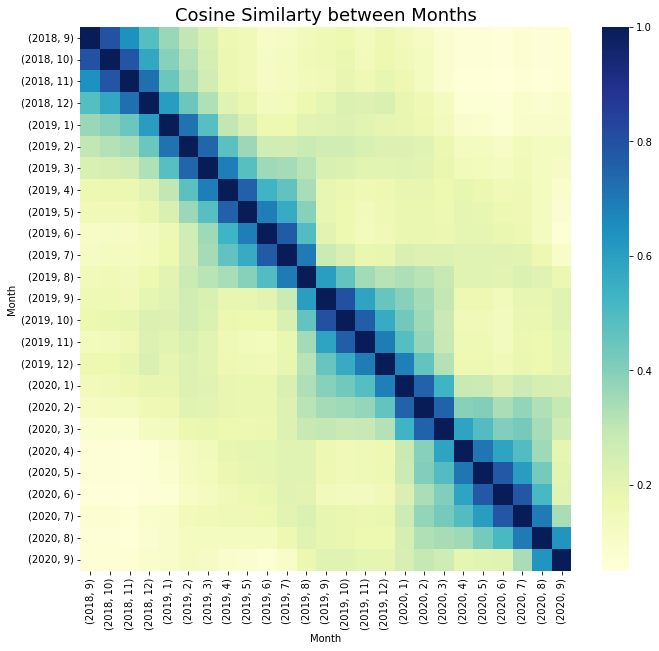

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
# group df by month
group_month = transactions_merged.groupby(['year','month','article_id'])['customer_id'].count().unstack(2)
group_month_idx = group_month.index
group_month = group_month.fillna(0).to_numpy()

# calculate cosine similarity matrix
mat_cos_month = list()
for vec_1 in group_month:
    for vec_2 in group_month:
        mat_cos_month.append(cosine_similarity([vec_1],[vec_2]))
mat_cos_month = np.array(mat_cos_month).reshape((25,25))

# plot the result
fig, ax = plt.subplots(figsize=(11,10))
ax = sns.heatmap(mat_cos_month, cmap="YlGnBu",xticklabels = group_month_idx , yticklabels = group_month_idx)
ax.set_title('Cosine Similarty between Months', fontsize=18)
ax.set_xlabel('Month')
ax.set_ylabel('Month')
plt.show()

**The darker and bluer the color is, the more similar they are. We see that closer the months are, the more similar they are. Also, we see that the color gets bluer in the middle. It seems that is due to the seasonality.**

In [37]:
# add week of the year to df
#transactions_merged['week'] = pd.DatetimeIndex(transactions_merged.t_dat).week

# group df by week of the year
group_week = transactions_merged.groupby(['year','week','article_id'])['customer_id'].count().unstack(2)
group_week_idx = group_week.index
group_week = group_week.fillna(0).to_numpy()

# calculate cosine similarity matrix
mat_cos_week = list()
for vec_1 in group_week:
    for vec_2 in group_week:
        mat_cos_week.append(cosine_similarity([vec_1],[vec_2]))
mat_cos_week = np.array(mat_cos_week).reshape((len(group_week_idx),len(group_week_idx)))

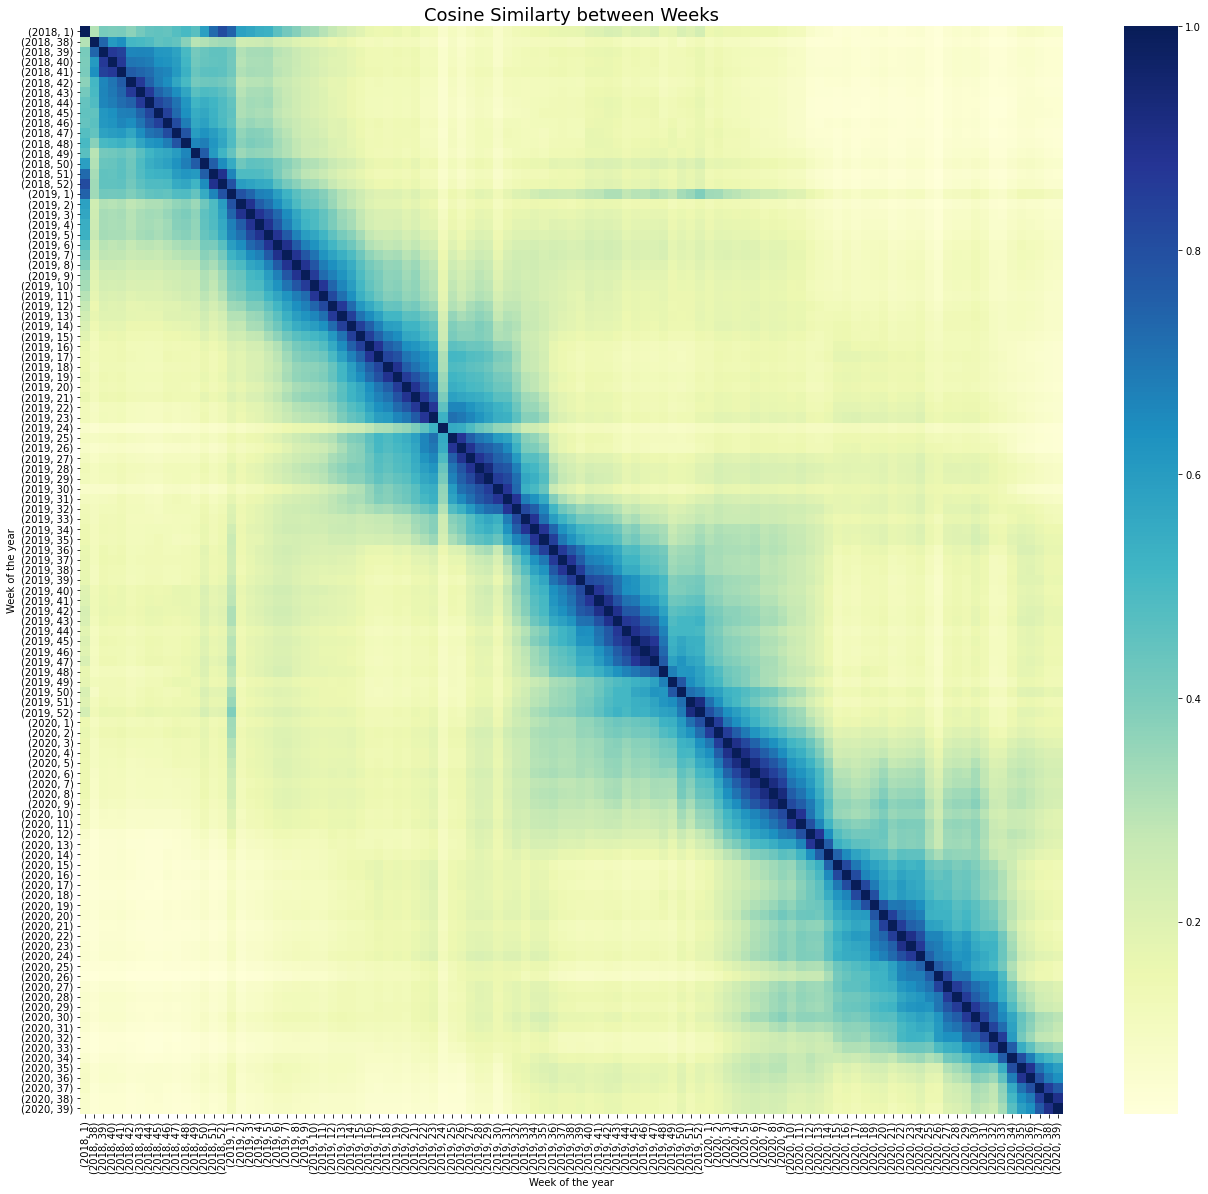

In [38]:
# plot the result
fig, ax = plt.subplots(figsize=(22,20))
ax = sns.heatmap(mat_cos_week, cmap="YlGnBu",xticklabels = group_week_idx , yticklabels = group_week_idx)
ax.set_title('Cosine Similarty between Weeks', fontsize=18)
ax.set_xlabel('Week of the year')
ax.set_ylabel('Week of the year')
plt.show()

**As shown above, the next week's composition of articles sold is highly related to the previous week's composition. Also, we see that the similarity decreases as the difference between the two time periods gets bigger. If I can find good clusters, I will be able tomake good recommendations to a customer by recommending the things which were purchased recently by customers in the same cluster**

# 2.Feature Engineering

I'm going to find clusters with customers' shopping patterns, depending on how many items customers buy from each category.

## 2.1 Selecting category

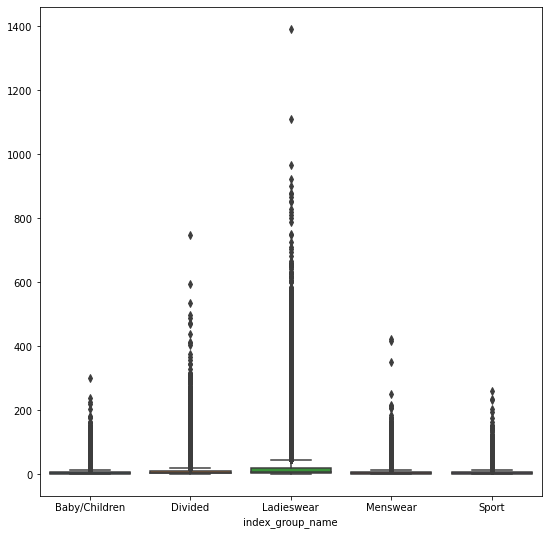

In [47]:
plt.figure(figsize = (9,9))
customer_grouped = transactions_merged.groupby(['customer_id','index_group_name']).sales_channel_id.count()
customer_grouped = customer_grouped.unstack(-1)
sns.boxplot(data=customer_grouped)
plt.show()

In [59]:
customer_grouped.describe()

index_group_name  Baby/Children        Divided    Ladieswear       Menswear  \
count             225761.000000  878590.000000  1.199964e+06  339126.000000   
mean                   5.392202       8.124670  1.701323e+01       5.222404   
std                    7.850203      12.578667  2.780209e+01       7.477168   
min                    1.000000       1.000000  1.000000e+00       1.000000   
25%                    1.000000       2.000000  3.000000e+00       1.000000   
50%                    3.000000       4.000000  7.000000e+00       3.000000   
75%                    6.000000       9.000000  2.000000e+01       6.000000   
max                  301.000000     746.000000  1.392000e+03     422.000000   

index_group_name          Sport  
count             319308.000000  
mean                   3.903466  
std                    5.091067  
min                    1.000000  
25%                    1.000000  
50%                    2.000000  
75%                    5.000000  
max                  260.000000

**Customer buy more things from Ladieswear category. Since its mean and variance is high, it will affect the effectivity of clustering. Thus, I will divide the category into more subcategories.**

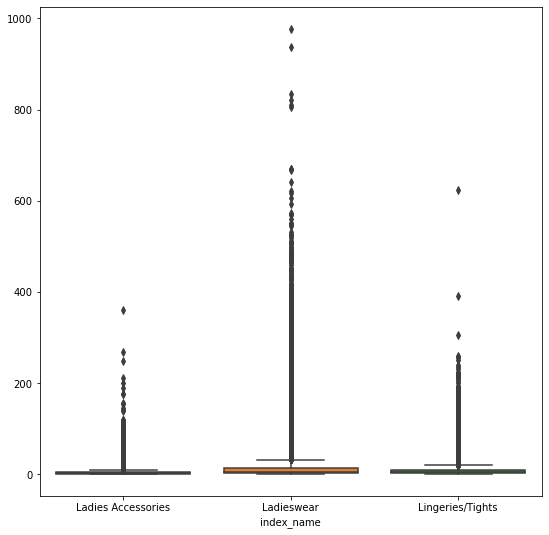

In [48]:
plt.figure(figsize = (9,9))
customer_grouped_2 = transactions_merged[transactions_merged['index_group_name']=='Ladieswear'].groupby(['customer_id','index_name']).sales_channel_id.count()
customer_grouped_2 = customer_grouped_2.unstack(-1)
sns.boxplot(data=customer_grouped_2)
plt.show()

In [60]:
customer_grouped_2.describe()

index_name  Ladies Accessories    Ladieswear  Lingeries/Tights
count            497359.000000  1.044894e+06     723357.000000
mean                  3.568310  1.249723e+01          7.717138
std                   4.650737  2.102550e+01         10.119812
min                   1.000000  1.000000e+00          1.000000
25%                   1.000000  2.000000e+00          2.000000
50%                   2.000000  5.000000e+00          4.000000
75%                   4.000000  1.400000e+01          9.000000
max                 360.000000  9.770000e+02        624.000000

**The mean and the variance of sublevel Ladieswear category is still higher. I will break down the cateogory one more time.**

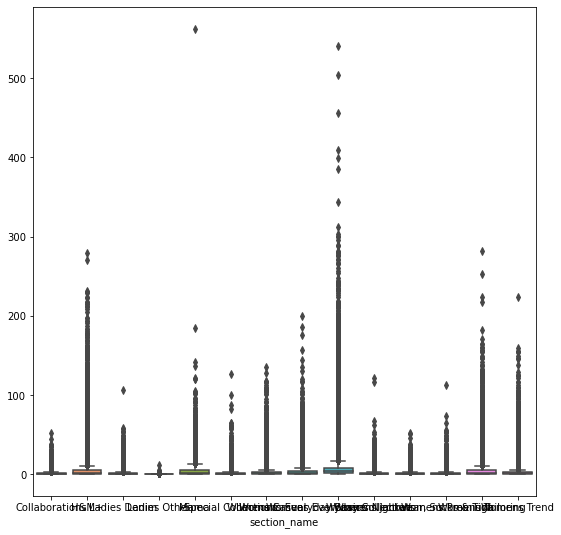

In [56]:
plt.figure(figsize = (9,9))
customer_grouped_3 = transactions_merged[transactions_merged['index_name']=='Ladieswear'].groupby(['customer_id','section_name']).sales_channel_id.count()
customer_grouped_3 = customer_grouped_3.unstack(-1)
sns.boxplot(data=customer_grouped_3)
plt.show()

In [61]:
customer_grouped_3.describe()

section_name  Collaborations          H&M+  Ladies Denim  Ladies Other  \
count           23290.000000  98462.000000  67074.000000    836.000000   
mean                1.979605      5.669131      2.021007      1.216507   
std                 2.305729     11.557672      2.526137      0.609124   
min                 1.000000      1.000000      1.000000      1.000000   
25%                 1.000000      1.000000      1.000000      1.000000   
50%                 1.000000      2.000000      1.000000      1.000000   
75%                 2.000000      5.000000      2.000000      1.000000   
max                52.000000    279.000000    107.000000     12.000000   

section_name          Mama  Special Collections  Womens Casual  \
count         52644.000000         23176.000000  408381.000000   
mean              4.754217             2.179410       3.008034   
std               7.083754             3.287333       3.719124   
min               1.000000             1.000000       1.000000   
25%               1.000000             1.000000       1.000000   
50%               2.000000             1.000000       2.000000   
75%               6.000000             2.000000       3.000000   
max             562.000000           127.000000     135.000000   

section_name  Womens Everyday Basics  Womens Everyday Collection  \
count                  449875.000000               817652.000000   
mean                        3.427316                    7.167881   
std                         4.162952                   10.899770   
min                         1.000000                    1.000000   
25%                         1.000000                    2.000000   
50%                         2.000000                    4.000000   
75%                         4.000000                    8.000000   
max                       200.000000                  541.000000   

section_name  Womens Jackets  Womens Nightwear, Socks & Tigh  Womens Premium  \
count          183984.000000                   101580.000000    64306.000000   
mean                1.944810                        1.803623        1.988010   
std                 1.973848                        1.625868        2.266121   
min                 1.000000                        1.000000        1.000000   
25%                 1.000000                        1.000000        1.000000   
50%                 1.000000                        1.000000        1.000000   
75%                 2.000000                        2.000000        2.000000   
max               122.000000                       52.000000      113.000000   

section_name  Womens Tailoring   Womens Trend  
count            521848.000000  194985.000000  
mean                  4.089311       2.988091  
std                   5.715630       4.729418  
min                   1.000000       1.000000  
25%                   1.000000       1.000000  
50%                   2.000000       2.000000  
75%                   5.000000       3.000000  
max                 282.000000     224.000000

**Now the categories are broken down enough that all the categories have similar mean and variance. I will convert the data into the percentage of the total purchase since that will better represent the pattern**

In [51]:
customer_group_merged  = customer_grouped.drop(columns='Ladieswear').join(customer_grouped_2.drop(columns='Ladieswear'), how='outer',rsuffix = 'index').join(customer_grouped_3, how='outer',rsuffix = 'section')
customer_group_merged = customer_group_merged.fillna(0)
customer_group_merged['total'] = customer_group_merged.sum(axis=1)

for c in customer_group_merged.columns:
    customer_group_merged[c] /= customer_group_merged['total']
customer_group_merged = customer_group_merged.drop(columns=['total'])

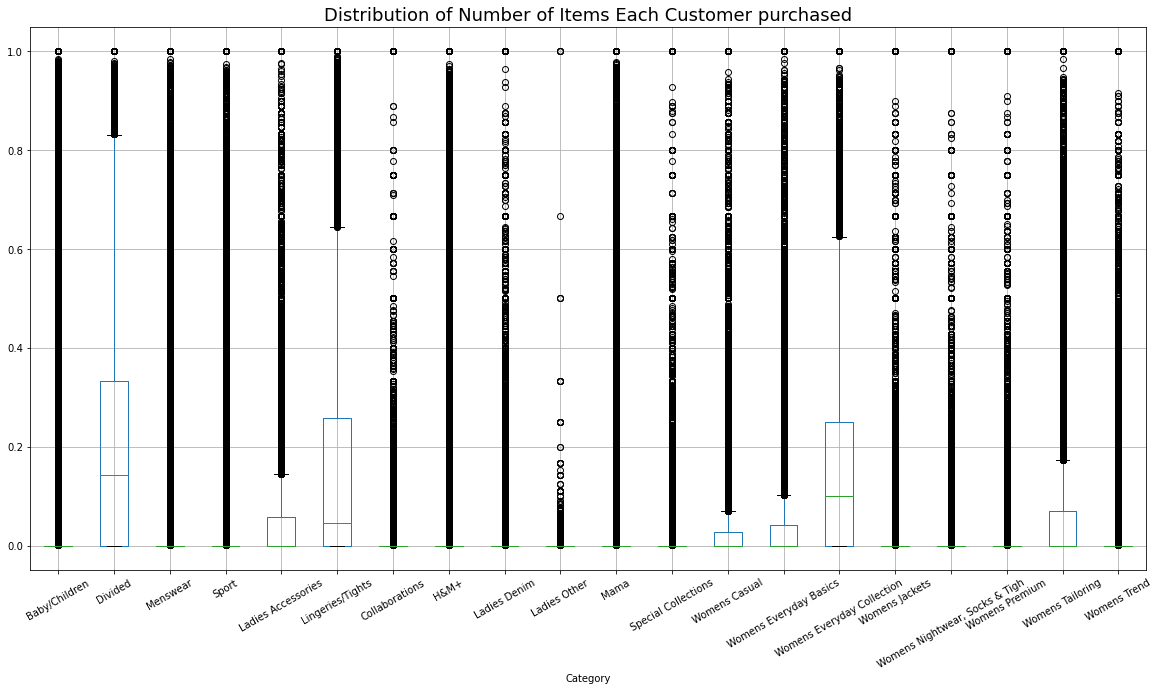

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
ax = customer_group_merged.boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title('Distribution of Number of Items Each Customer purchased',fontsize=18)
ax.set_xlabel('Category')
plt.show()

# 3.K-means Clustering

For n_clusters = 2 The average silhouette_score is : 0.15003498081614788


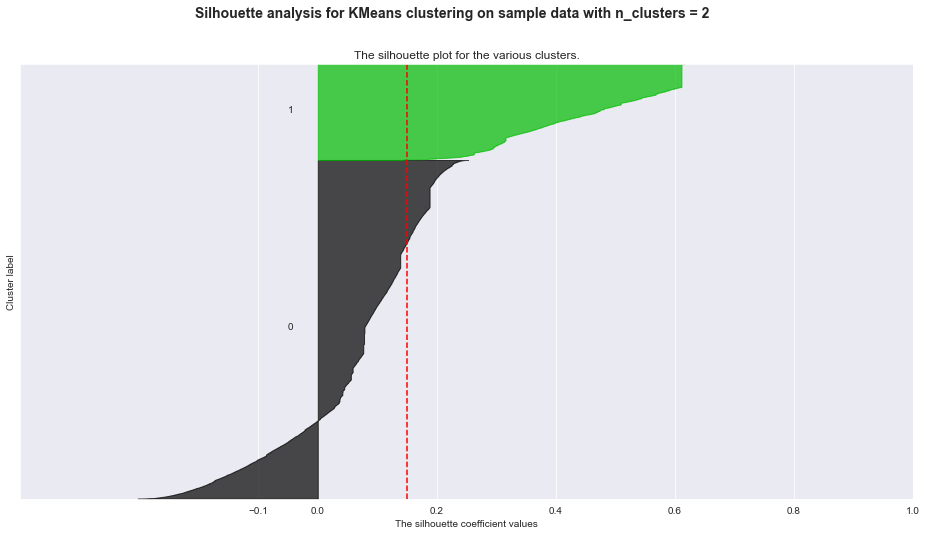

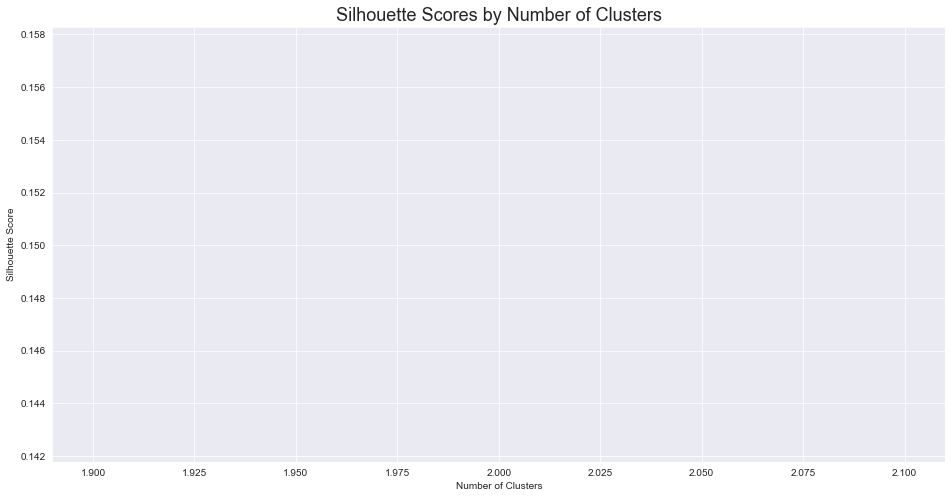

In [69]:
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.cm as cm

train = customer_group_merged

# sample datapoints for faster silhouette calculation
number_of_samples = 70000
np.random.seed(47) # assign random seed for reproducibility
sample_indices = np.random.choice(customer_group_merged.shape[0], number_of_samples, replace=False)
X = train.iloc[sample_indices,:]
range_n_clusters = range(2,15)
sil_scores = list()
for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(figsize=(16,8))

    # The silhouette coefficient can range from -1, 1 but in this example all
    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 47 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=47)
    cluster_labels = clusterer.fit_predict(train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    labels_sampled = cluster_labels[sample_indices]
    silhouette_avg_sampled = silhouette_score(X, labels_sampled)
    # append the result to plot later
    sil_scores.append(silhouette_avg_sampled)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg_sampled,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels_sampled)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels_sampled == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_sampled, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.3,1.1,0.1))

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
    plt.show() 
    
    
df_sil_scores = pd.DataFrame([range_n_clusters,sil_scores]).T
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.lineplot(data=df_sil_scores, x=0, y=1)
ax.set_title('Silhouette Scores by Number of Clusters', fontsize=18)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
plt.show()

**9 seems to be the best number of clusters. The average silhouette score is one of the highest and the scores of the cluster does not fluctuate much.**

## 4.Results Interpretation

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
# Initialize the clusterer with n_clusters value and a random generator
# seed of 47 for reproducibility.
n_clusters = 9
clusterer = KMeans(n_clusters=n_clusters, random_state=47)
cluster_labels = clusterer.fit_predict(customer_group_merged)

In [ ]:
# show the summary of clustering
pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns = ['No. of customers']).T

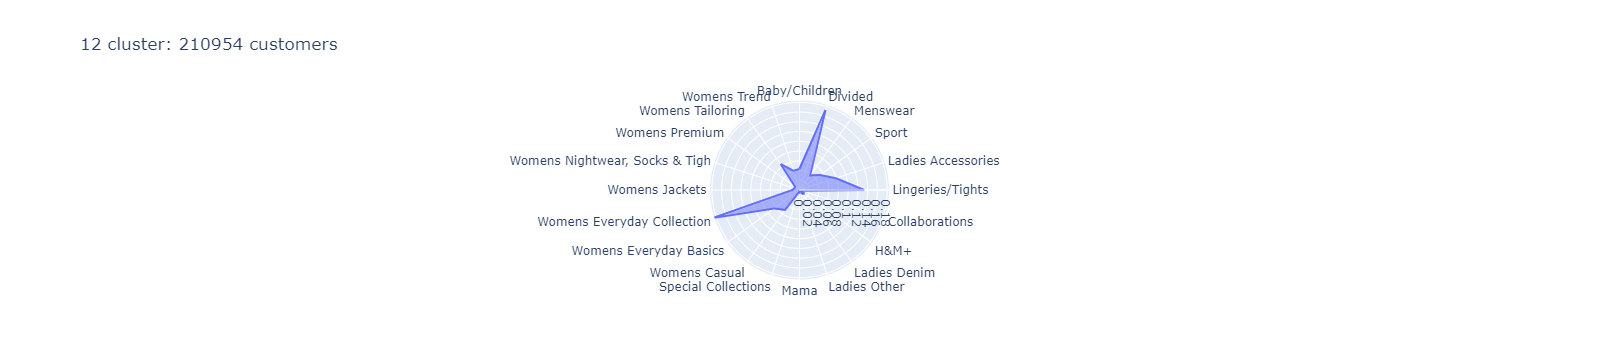

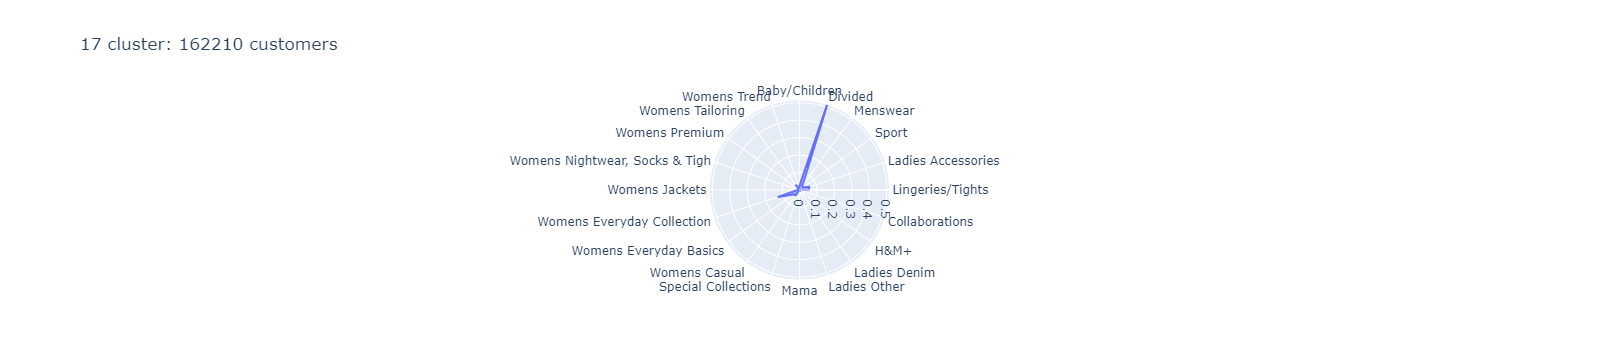

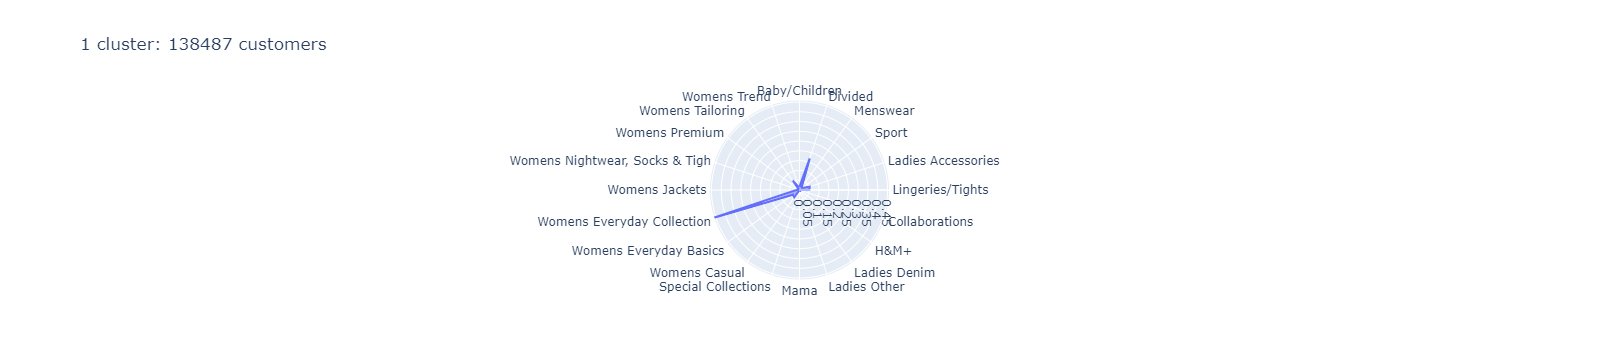

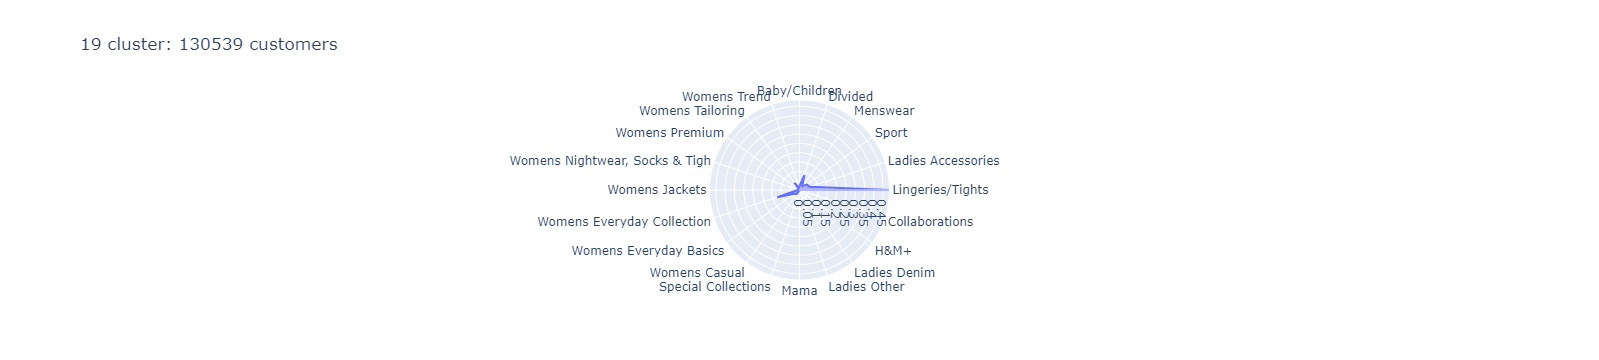

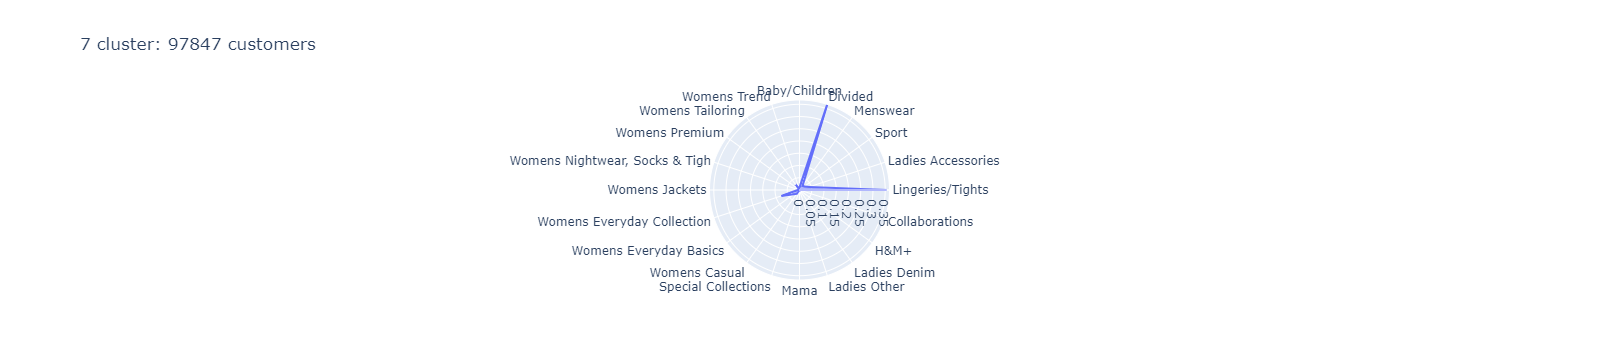

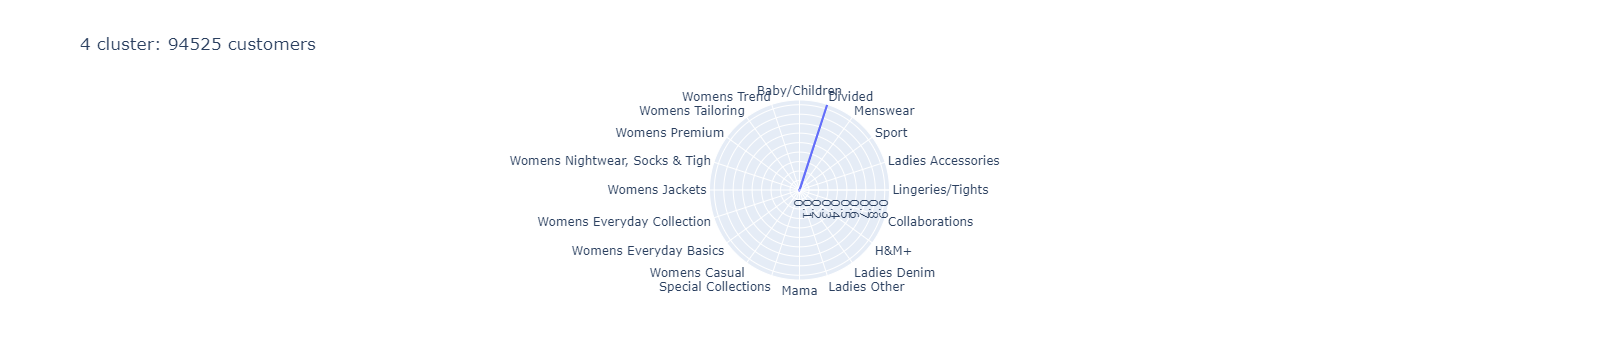

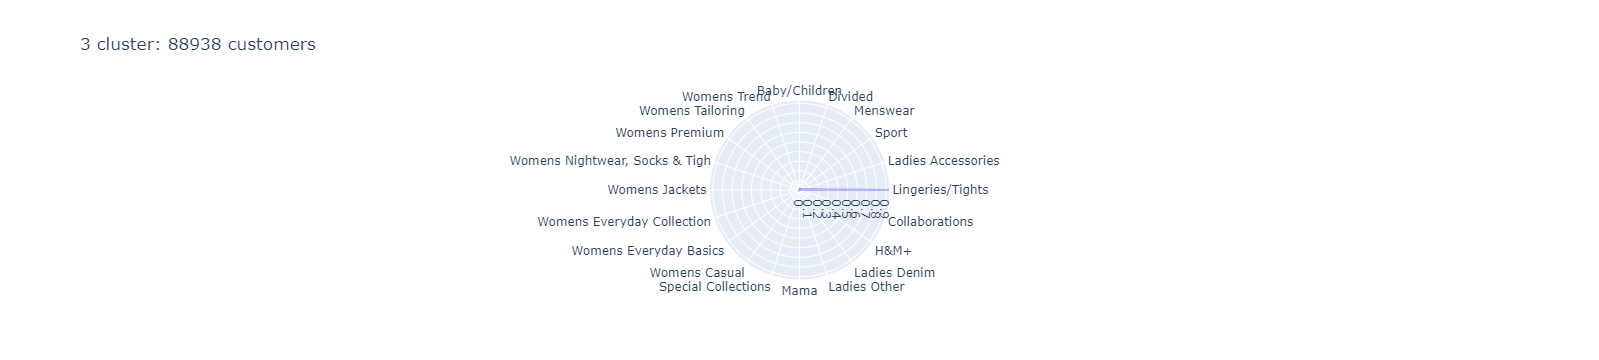

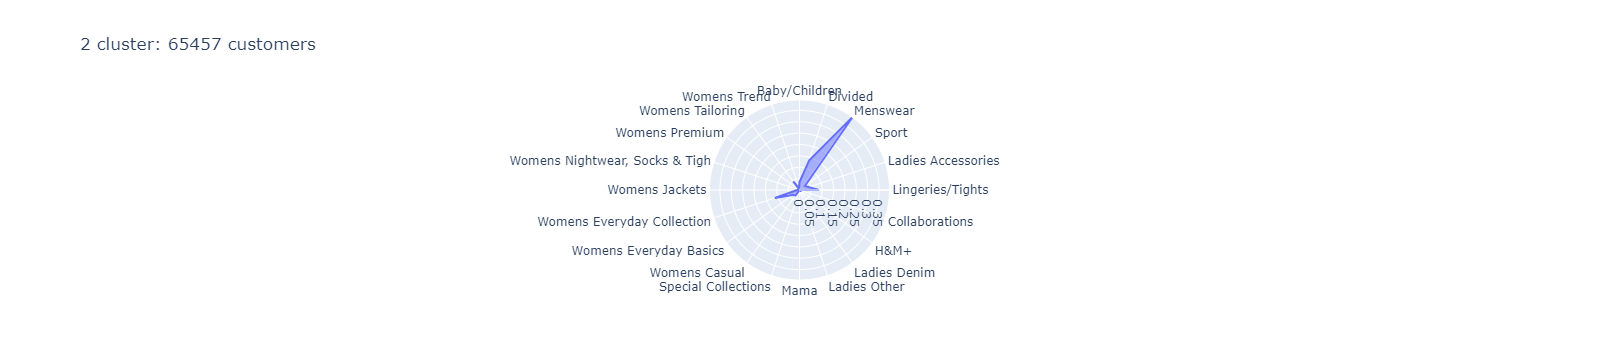

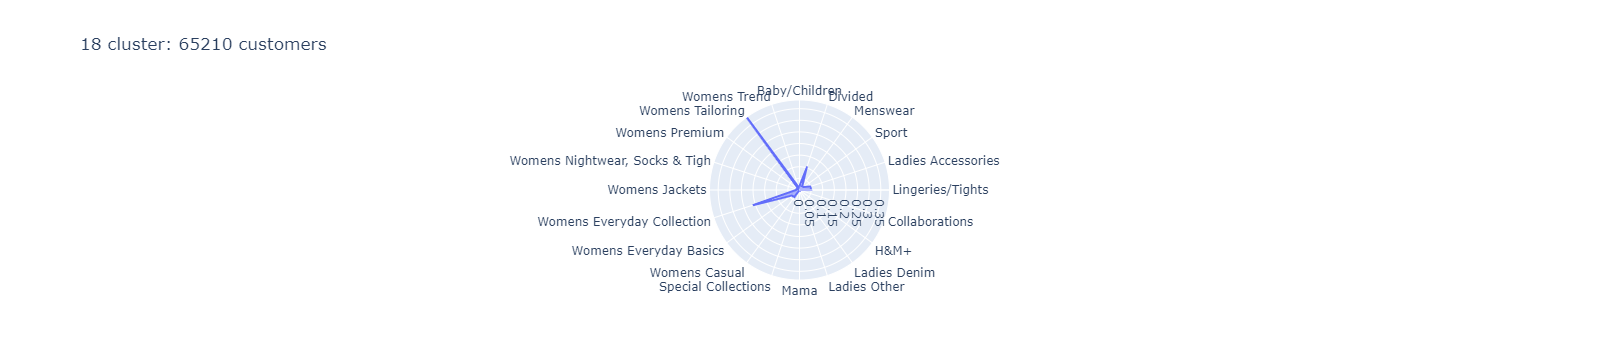

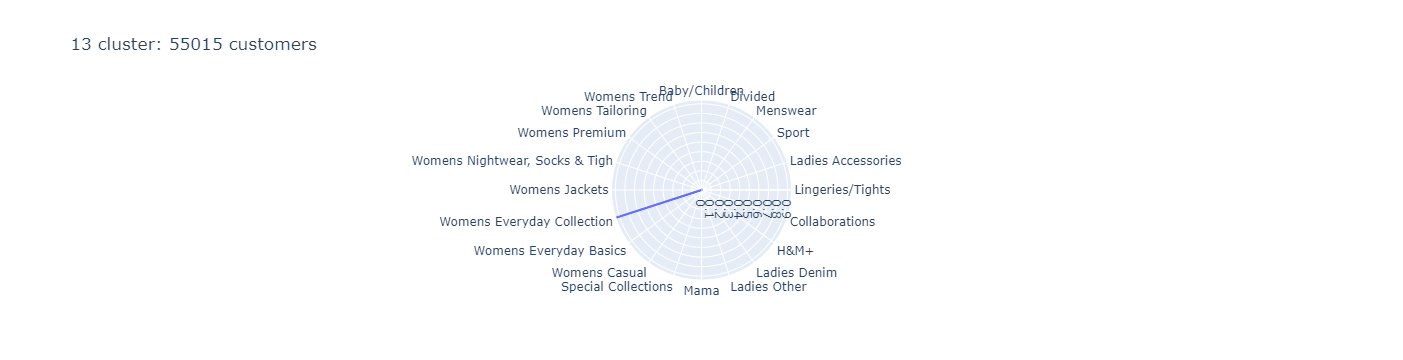

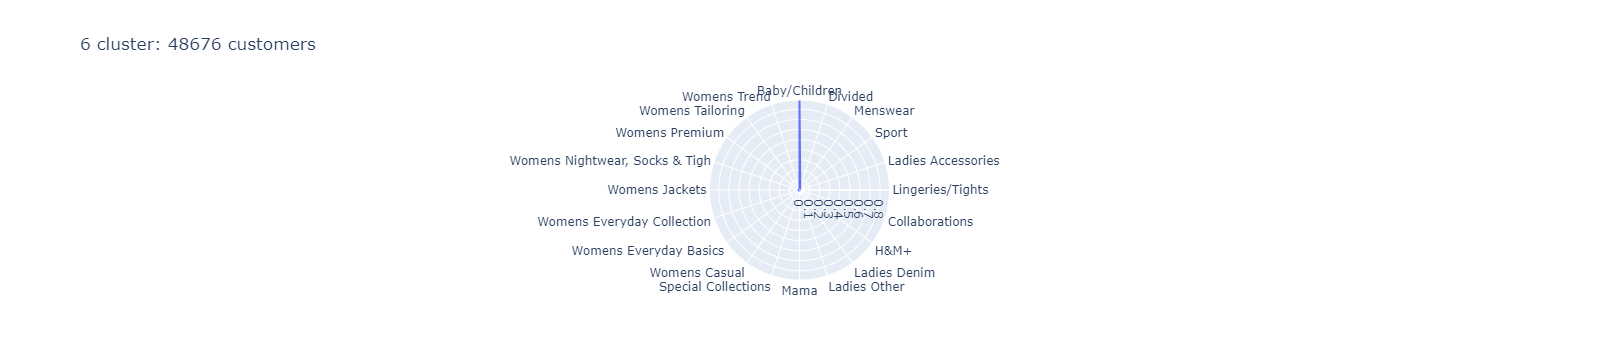

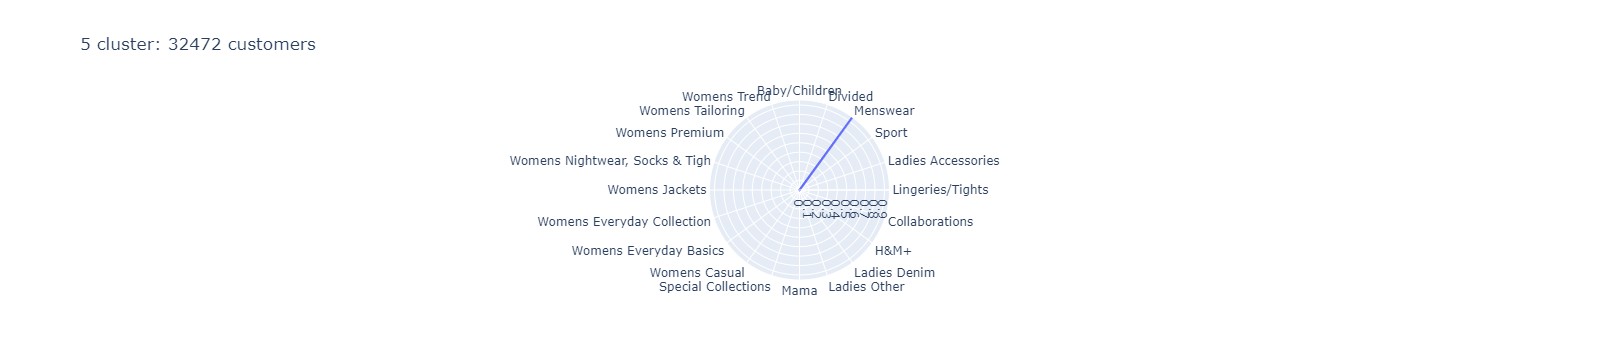

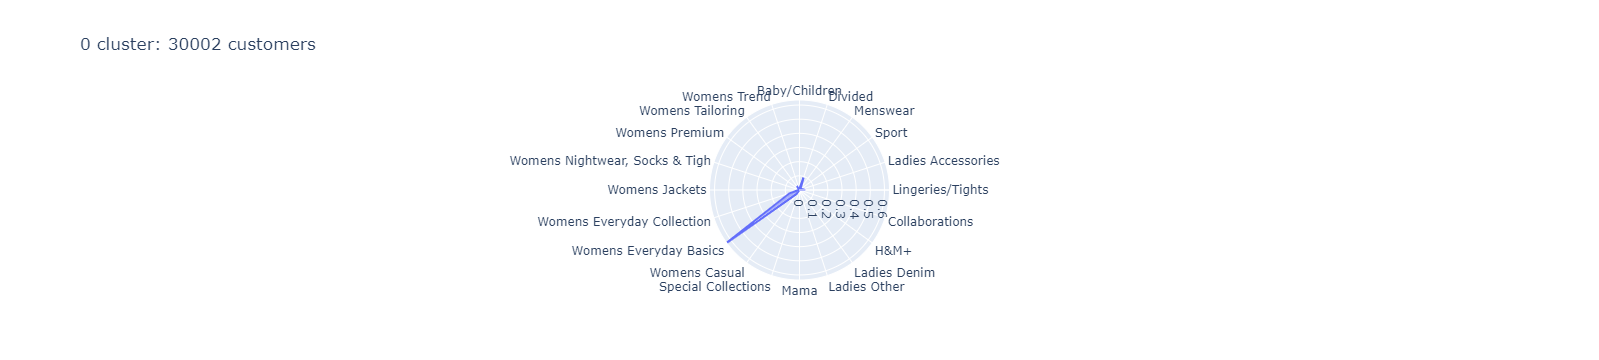

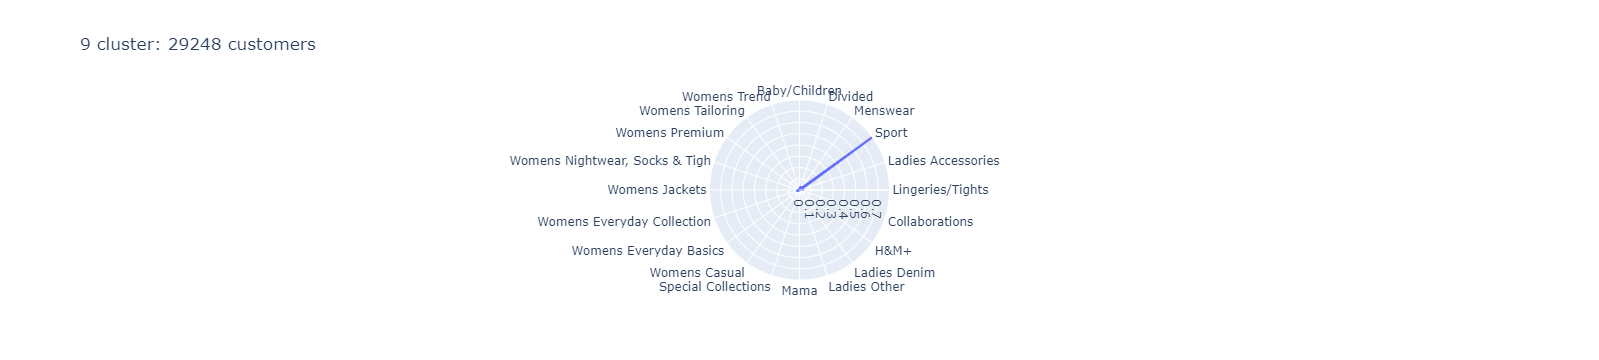

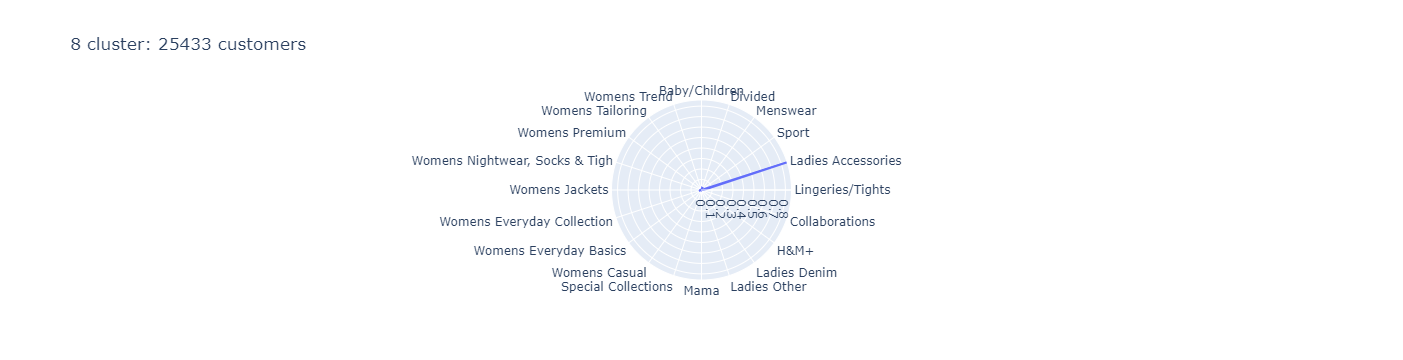

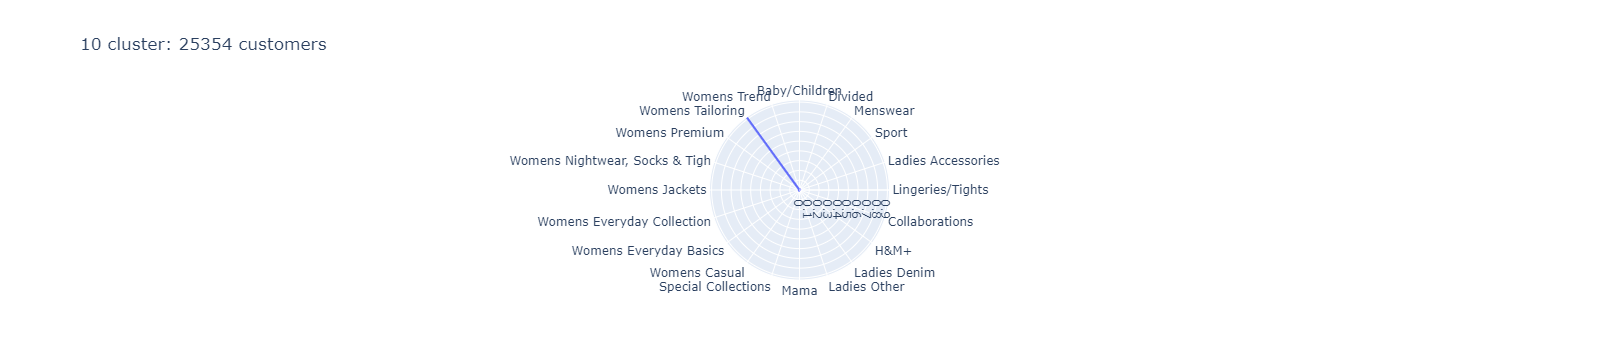

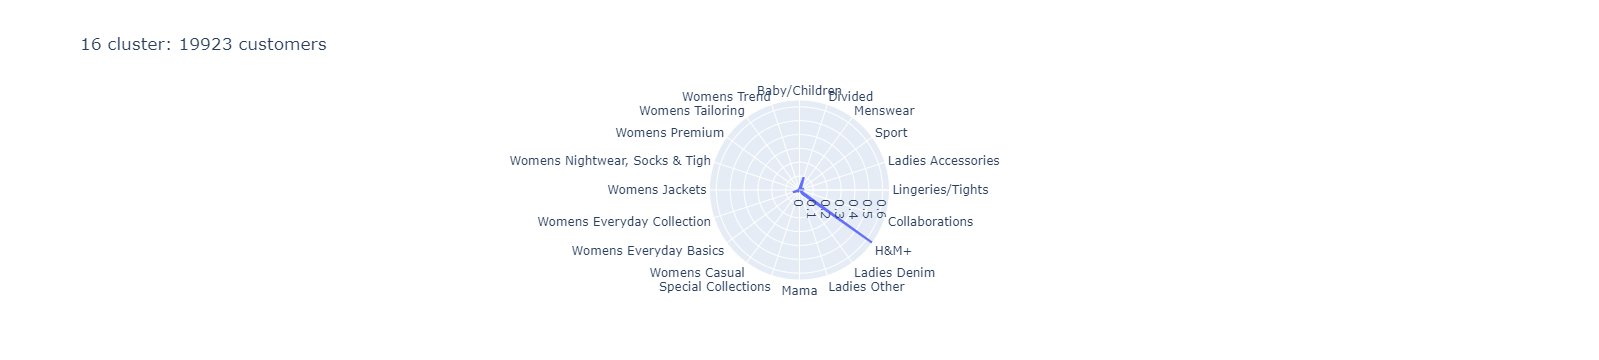

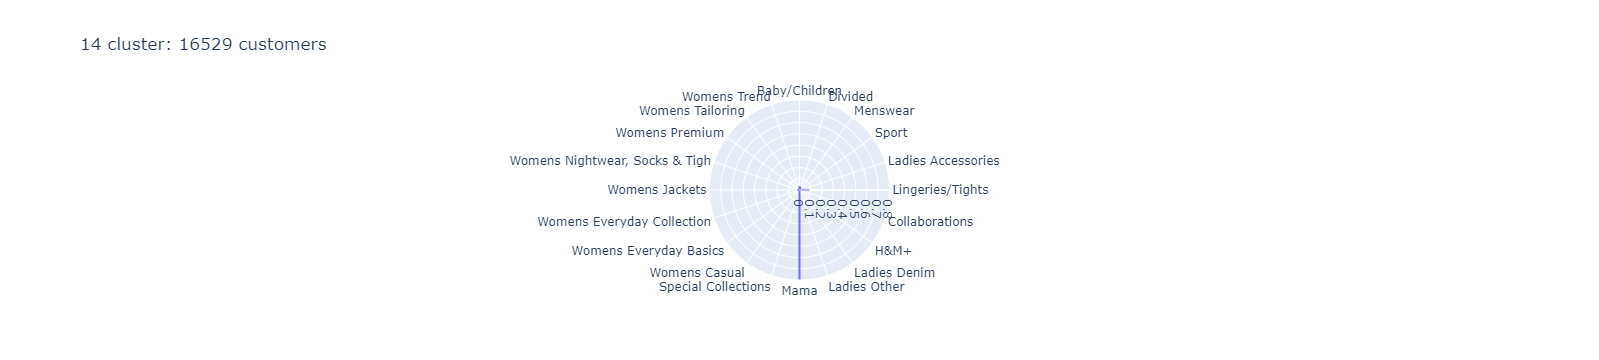

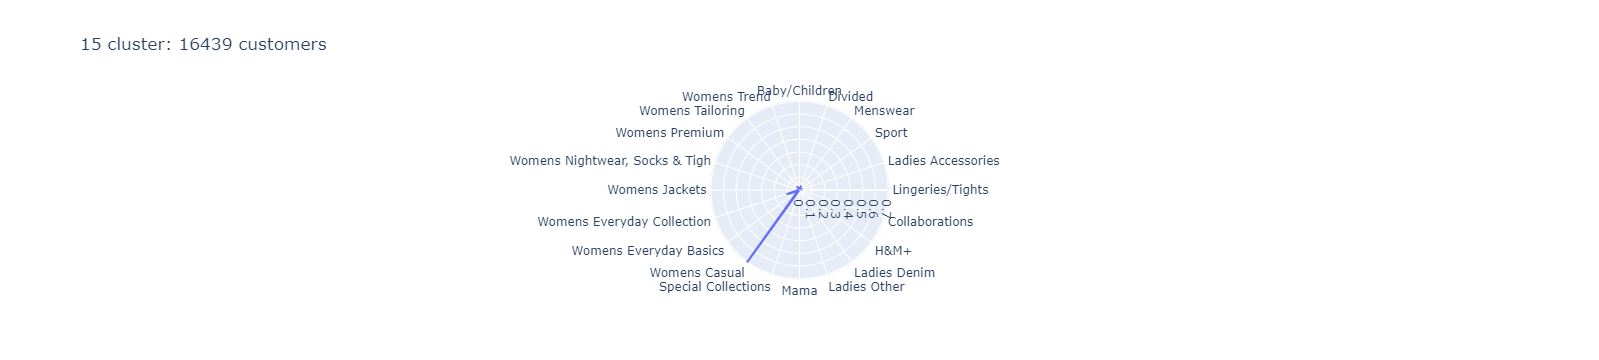

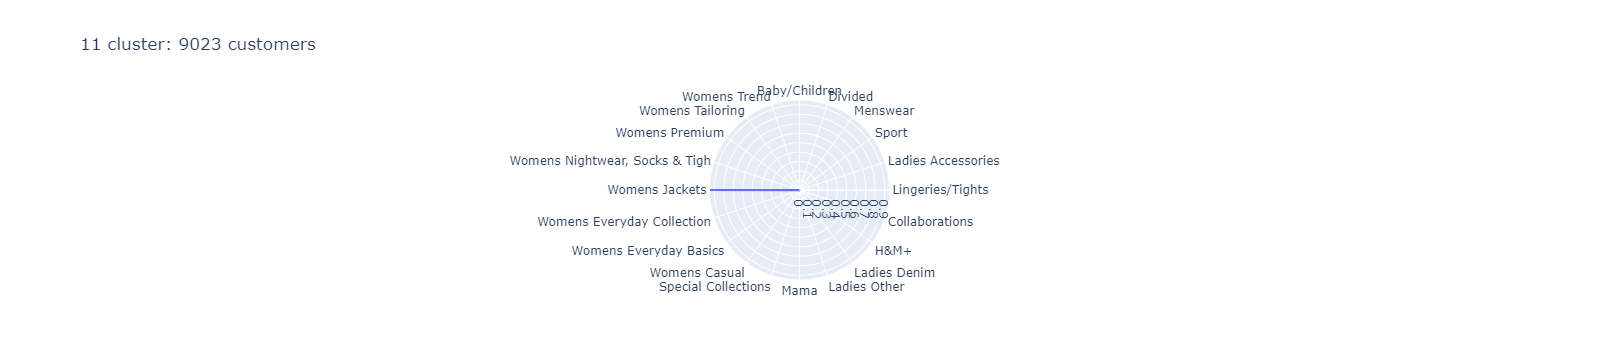

In [388]:
import plotly.express as px
centers = pd.DataFrame(clusterer.cluster_centers_).T
centers['r'] = customer_group_merged.columns
cluster_order = pd.Series(cluster_labels).value_counts().iteritems()
# show the radar plot for each cluster in the order of the number of customers

for i, number in cluster_order:
    fig = px.line_polar(centers, r=i, theta='r', line_close=True,title=f'{i} cluster: {number} customers')
    fig.update_traces(fill='toself')
    fig.show()

**Though the silhoutte scores is not so high, I still see the cluster has different characteristics. (EXPLAIN MORE ABOUT EACH SEGMENT). \
I will move on to make recommendation and see if the approach works**

In [179]:
# make a df with customer_id and cluster label
df_cluster_labels = pd.DataFrame(data=cluster_labels, index=customer_group_merged.index,columns=['cluster']).reset_index()
dd_cluster_labels = dd.from_pandas(df_cluster_labels, npartitions=3)
# del df_cluster_labels

## Make Recommendation

In [33]:
transaction_with_cluster_label = transactions_merged[['t_dat','article_id','customer_id']]

In [34]:
transaction_with_cluster_label = transaction_with_cluster_label.merge(dd_cluster_labels, how='left', on = 'customer_id',suffixes=('', '_y'))

In [ ]:
transaction_with_cluster_label = transaction_with_cluster_label.drop(columns=['customer_id'])

In [44]:
transaction_with_cluster_label.info

<bound method DataFrame.info of Dask DataFrame Structure:
                         t_dat article_id customer_id cluster
npartitions=54                                               
                datetime64[ns]      int64      object   int32
                           ...        ...         ...     ...
...                        ...        ...         ...     ...
                           ...        ...         ...     ...
                           ...        ...         ...     ...
Dask Name: assign, 1046 tasks>

In [54]:
%%time
(transaction_with_cluster_label['t_dat'] <= '2018-09-21').sum().compute()

Wall time: 3min 50s


95942

In [283]:
%%time
df_recs_final = transaction_with_cluster_label[transaction_with_cluster_label['t_dat'] >= pd.to_datetime(dates.max()) - pd.DateOffset(days =3)].groupby(['cluster','article_id']).count().compute()

Wall time: 7min 23s


In [284]:
df_recs_final = df_recs_final.sort_values(['t_dat'],ascending=False).reset_index()

In [285]:
# make dictionary of recs for each cluster
dic_recs = {}
num_cluster = 20
for i in range(num_cluster):
    dic_recs[i] = ' '.join([str(a).zfill(10) for a in df_recs_final[df_recs_final['cluster'] == i].iloc[:12,1].values]) # make the list into string for formatting
dic_recs[999] = ' '.join([str(a).zfill(10) for a in df_recs_final.iloc[:12,1].values])

In [268]:
dic_recs

{0: '0610776002 0768912001 0800691007 0803757001 0778064003 0456163086 0803757004 0610776001 0778064001 0841383002 0800691008 0456163060',
 1: '0915526001 0751471043 0751471001 0915529003 0909370001 0896152002 0924243001 0918522001 0898694001 0933706001 0863595006 0915526002',
 2: '0685813001 0685814001 0685816002 0685813043 0685813037 0685814022 0685814003 0685816001 0685813042 0720504010 0685814063 0685814033',
 3: '0758034001 0611415001 0158340001 0160442007 0885951001 0160442010 0557599022 0858147001 0719655001 0819113001 0860797001 0803468002',
 4: '0706016001 0715624001 0448509014 0706016003 0706016002 0717464001 0715624010 0621381012 0914441004 0715624013 0715624053 0760084003',
 5: '0685814001 0685813001 0715255013 0685814003 0685814048 0685814022 0685813003 0720504010 0685813037 0685814063 0781758003 0685814033',
 6: '0715624010 0787946002 0831939004 0715624001 0751471001 0911214001 0685814001 0805000001 0677930086 0857347002 0750481010 0870525005',
 7: '0448509014 0706016001 

In [188]:
submission = pd.read_csv(data_path /"sample_submission.csv")

In [ ]:
# add cluster info to customer_id
# filter
## previous 7 days(need to test), cluster
# aggregate(sum)
# sort and recommend
# format: df
## columns:

In [286]:
submission = submission.merge(df_cluster_labels, how='left', on='customer_id')
submission['cluster'] = submission['cluster'].fillna(999)
submission['prediction'] = submission['cluster'].map(dic_recs)

In [287]:
submission = submission.drop(columns='cluster')

In [288]:
submission

customer_id  \
0        00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1        0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2        000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3        00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4        00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   
...                                                    ...   
1371975  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...   
1371976  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...   
1371977  ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...   
1371978  ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...   
1371979  ffffd9ac14e89946416d80e791d064701994755c3ab686...   

                                                prediction  
0        0762846027 0850917001 0762846031 0912100001 09...  
1        0158340001 0918292001 0866731001 0918522001 06...  
2        0158340001 0918292001 0866731001 0918522001 06...  
3        0866731001 0918292001 0918292004 0791587001 08...  
4        0158340001 0918292001 0866731001 0918522001 06...  
...                                                    ...  
1371975  0611415001 0855706009 0158340001 0891763001 07...  
1371976  0448509014 0874110016 0706016003 0788575004 07...  
1371977  0448509014 0874110016 0706016003 0788575004 07...  
1371978  0448509014 0714790020 0909059002 0788575002 08...  
1371979  0906372001 0898886001 0914118001 0552716001 09...  

[1371980 rows x 2 columns]

In [289]:
submission.to_csv(data_path /"submission_20_clu_3_days.csv", index=False, header=True)

In [277]:
%%time
df_temp = transaction_with_cluster_label[transaction_with_cluster_label['t_dat'] >= pd.to_datetime(dates.max()) - pd.DateOffset(days =7)].compute()
df_temp

Wall time: 7min 24s


t_dat  article_id  \
111507 2020-09-15   762063001   
111508 2020-09-15   909357001   
111509 2020-09-15   832312003   
111510 2020-09-15   826492001   
111511 2020-09-15   902161004   
...           ...         ...   
74708  2020-09-22   865917001   
74709  2020-09-22   669999001   
74710  2020-09-22   669999001   
74711  2020-09-22   788575004   
74712  2020-09-22   788575002   

                                              customer_id  cluster  
111507  001b09b8679f1efaefebab00c6d7fdeb036e2ca015605f...       12  
111508  001b09b8679f1efaefebab00c6d7fdeb036e2ca015605f...       12  
111509  03836fd3e97e3c7b499e94f17a1e507e8a3a6ab875a2d6...       12  
111510  05f8d4e14fadbb88ad9b3fb56150f5934da29e4f5ade58...        2  
111511  0788ff167c39344f1d487c23ea24df71927e1b8d69e3a9...        7  
...                                                   ...      ...  
74708   fddb1df1284df3c4e623c0e9fac1ba8e7ba631cd84a0fd...       12  
74709   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  
74710   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  
74711   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  
74712   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  

[266364 rows x 4 columns]

In [282]:
df_temp.t_dat.unique()

array(['2020-09-15T00:00:00.000000000', '2020-09-16T00:00:00.000000000',
       '2020-09-17T00:00:00.000000000', '2020-09-18T00:00:00.000000000',
       '2020-09-19T00:00:00.000000000', '2020-09-20T00:00:00.000000000',
       '2020-09-21T00:00:00.000000000', '2020-09-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [290]:
df_recs_final.t_dat.unique()

array([140, 135, 133, 130, 119, 115, 110, 109, 107, 106,  99,  98,  97,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  82,  78,  77,
        76,  75,  74,  73,  72,  71,  68,  67,  66,  65,  64,  63,  62,
        61,  60,  59,  58,  57,  56,  55,  53,  51,  50,  49,  48,  47,
        46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,
        33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,
        20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,
         7,   6,   5,   4,   3,   2,   1], dtype=int64)

In [304]:
from sklearn.cluster import MiniBatchKMeans, KMeans
# run Kmeans with 20 clusters

# Initialize the clusterer with n_clusters value and a random generator
# seed of 47 for reproducibility.
customer_group_merged_np = np.array(customer_group_merged)
n_clusters = 9
clusterer = KMeans(n_clusters=n_clusters, random_state=47)
cluster_labels = clusterer.fit_predict(customer_group_merged_np)

In [305]:
# show the summary of clustering
pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns = ['No. of customers']).T

4       3       2       5      1      0      7      6  \
No. of customers  595934  207377  183424  139209  61368  60971  49951  36897   

                      8  
No. of customers  27150

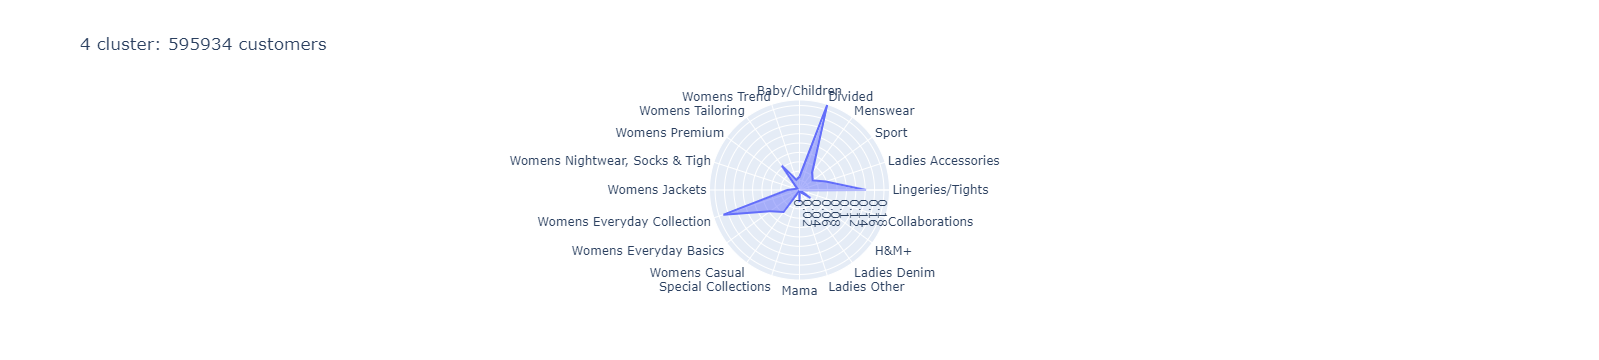

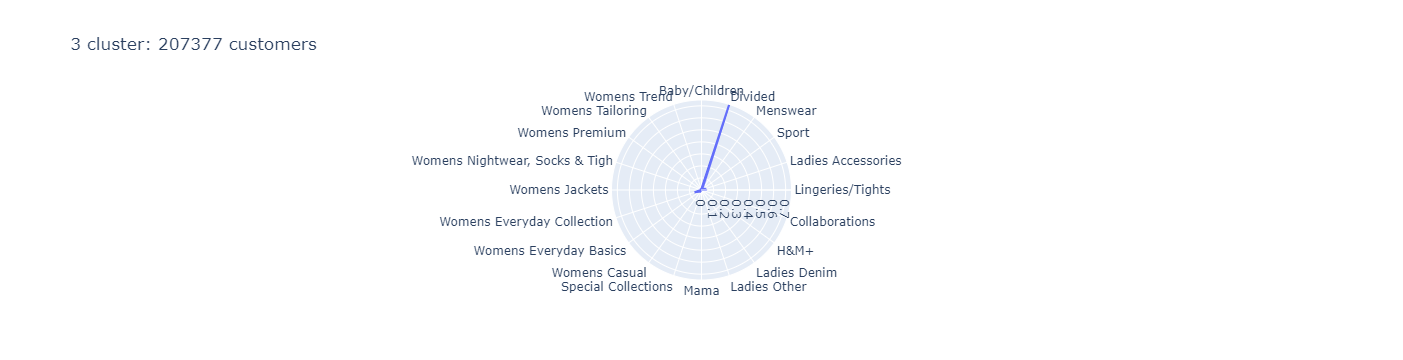

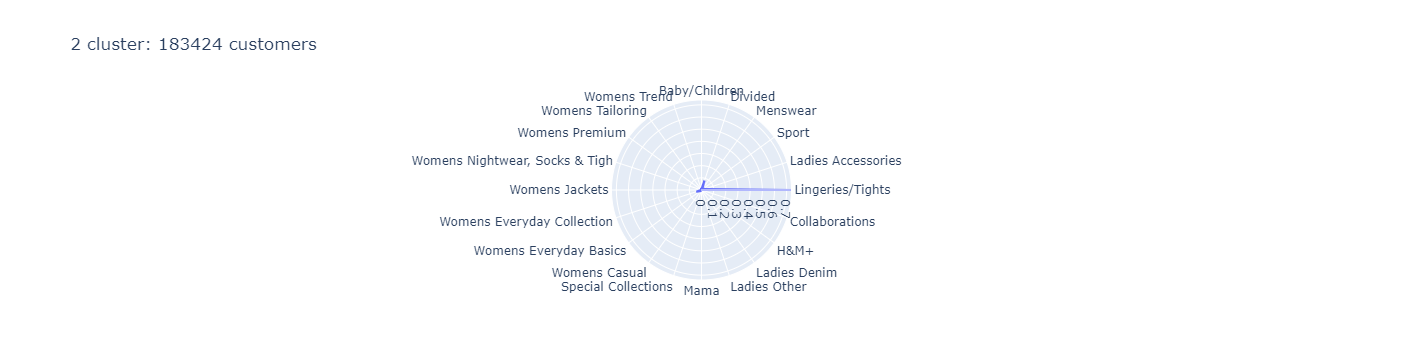

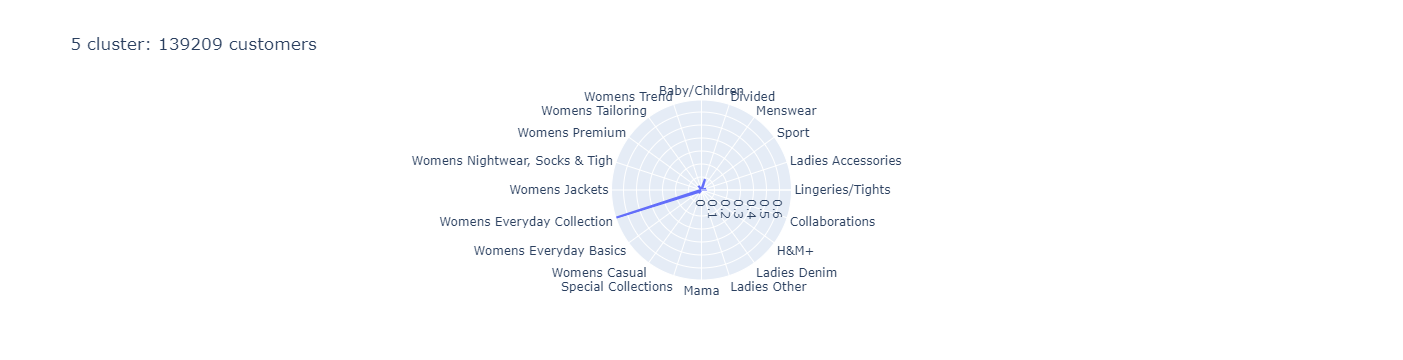

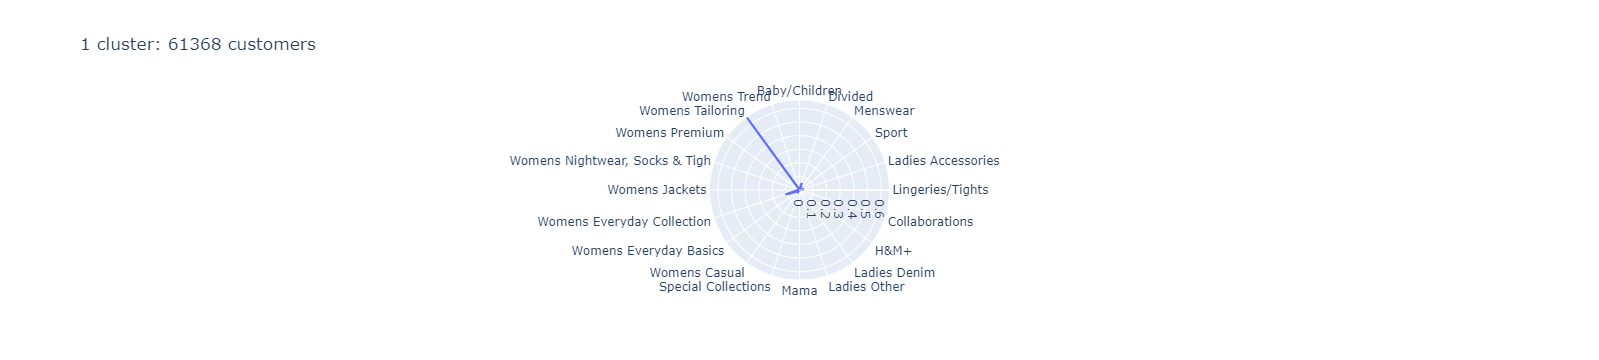

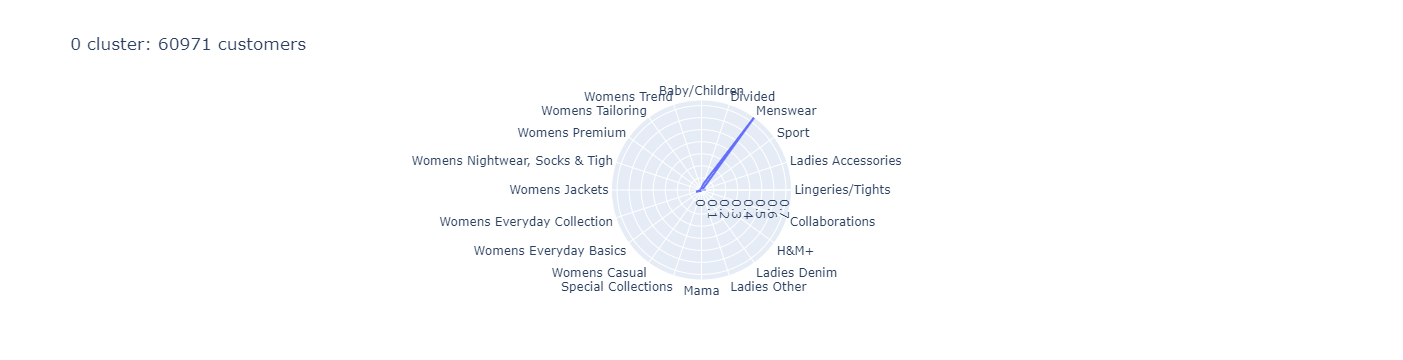

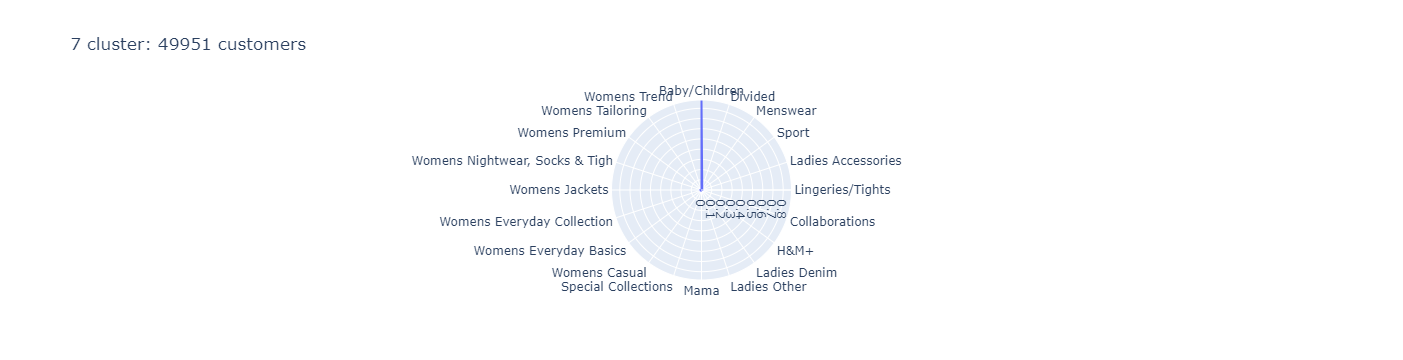

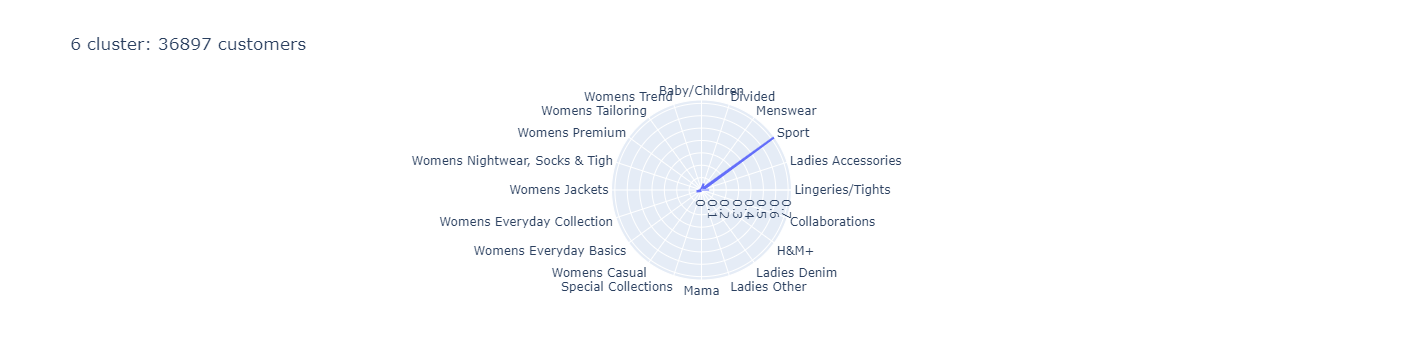

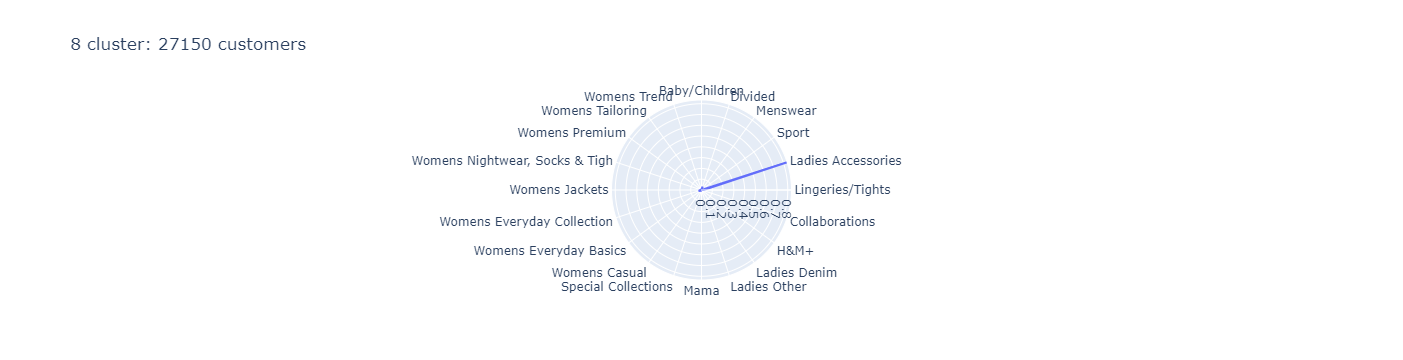

In [306]:
import plotly.express as px
centers = pd.DataFrame(clusterer.cluster_centers_).T
centers['r'] = customer_group_merged.columns
cluster_order = pd.Series(cluster_labels).value_counts().iteritems()
# show the radar plot for each cluster in the order of the number of customers

for i, number in cluster_order:
    fig = px.line_polar(centers, r=i, theta='r', line_close=True,title=f'{i} cluster: {number} customers')
    fig.update_traces(fill='toself')
    fig.show()

## The results with 20 clusters were not so good. Thus, I will try different clusters**